<a href="https://colab.research.google.com/github/Paqui-Ronvaldi/FP2021/blob/main/Horb_Exams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Горб Олександр Олександрович
ТШІ21
Практичне завдання іспиту з дисципліни
Методи обробки природномовної інформації
13.12.2021
Варіант 10

Завдання:

Розробити Jupyter Notebook для вирішення завдання класифікації тексту на основі набору даних:https://drive.google.com/drive/folders/1cYLsyazwxMUSICumvIhv5jGJe6K7iAHa?usp=sharing

Забезпечити виконання наступних етапів:

Завантаження та попередній аналіз даних.
Створення тренувального та тестувального наборів даних.
Попередню оцінку точності моделі за допомогою методу Naive Bayes.
Вирішення задачі класифікації за допомогою методу Bidirectional-GRU.
Графічне відображення тренування моделі.
Порівняння результатів, отриманих у п.п. 3,4
Висновки.

In [49]:
import pandas as pd
import random
import tensorflow as tf 
from matplotlib import pyplot as plt

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from plotly.subplots import make_subplots
import plotly.graph_objs as go

Завантаження та попередній аналіз даних.

In [50]:
train = pd.read_csv("train.csv")
test = pd.read_csv("valid.csv")

In [51]:
train_df = pd.concat([test,train], ignore_index=True )
train_df

,Id,Title,Body,Tags,CreationDate,Y
0,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
1,34554721,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,<php><mysql><sql><codeigniter><mysqli>,2016-01-01 08:43:50,LQ_EDIT
2,34555135,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,<python><pandas>,2016-01-01 09:55:22,HQ
3,34555448,Reader Always gimme NULL,"I'm so new to C#, I wanna make an application ...",<sql-server><c#-4.0>,2016-01-01 10:43:45,LQ_EDIT
4,34555752,php rearrange array elements based on condition,basically i have this array:\r\n\r\n array(...,<php>,2016-01-01 11:34:09,LQ_EDIT
...,...,...,...,...,...,...
59995,60461435,Convert List<String> to string C# - asp.net - ...,<p>I am new to this and I am asking for help t...,<c#><asp.net><sql-server>,2020-02-29 02:22:18,LQ_CLOSE
59996,60461754,Does Python execute code from the top or botto...,<p>I am working on learning Python and was won...,<python>,2020-02-29 03:33:59,LQ_CLOSE
59997,60462001,how to change payment date in Azure?,<p>It looks like it costs 8 days per month in ...,<azure><billing>,2020-02-29 04:34:16,LQ_CLOSE
59998,60465318,how to implement fill in the blank in Swift,"<p>""I _____ any questions.""</p>\n\n<p>I want t...",<ios><swift>,2020-02-29 12:50:43,LQ_CLOSE


In [52]:
def classes_def(x):
    if x == "LQ_CLOSE":
        return 0
    elif x == "LQ_EDIT":
        return 1
    else:
        return 2
    
train_df['target'] = train_df['Y'].apply(lambda x:classes_def(x))

In [53]:
train_df

,Id,Title,Body,Tags,CreationDate,Y,target
0,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT,1
1,34554721,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,<php><mysql><sql><codeigniter><mysqli>,2016-01-01 08:43:50,LQ_EDIT,1
2,34555135,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,<python><pandas>,2016-01-01 09:55:22,HQ,2
3,34555448,Reader Always gimme NULL,"I'm so new to C#, I wanna make an application ...",<sql-server><c#-4.0>,2016-01-01 10:43:45,LQ_EDIT,1
4,34555752,php rearrange array elements based on condition,basically i have this array:\r\n\r\n array(...,<php>,2016-01-01 11:34:09,LQ_EDIT,1
...,...,...,...,...,...,...,...
59995,60461435,Convert List<String> to string C# - asp.net - ...,<p>I am new to this and I am asking for help t...,<c#><asp.net><sql-server>,2020-02-29 02:22:18,LQ_CLOSE,0
59996,60461754,Does Python execute code from the top or botto...,<p>I am working on learning Python and was won...,<python>,2020-02-29 03:33:59,LQ_CLOSE,0
59997,60462001,how to change payment date in Azure?,<p>It looks like it costs 8 days per month in ...,<azure><billing>,2020-02-29 04:34:16,LQ_CLOSE,0
59998,60465318,how to implement fill in the blank in Swift,"<p>""I _____ any questions.""</p>\n\n<p>I want t...",<ios><swift>,2020-02-29 12:50:43,LQ_CLOSE,0


Допоміжні функції

In [54]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Обчислює accuracy, precision, recall and f1 моделі.

  Аргументи:
  -----
  y_true = реальні значення класу у вигляді 1-мірного масиву
  y_pred = прогнозовані значення класу у вигляді 1-мірного масиву

  Повертає словник зі значеннями accuracy, precision, recall, f1-score.
  """

  model_accuracy = accuracy_score(y_true, y_pred) * 100

  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [55]:
def compare_baseline_to_new_results(baseline_results, new_model_results):
  """
  Виводить accuracy, precision, recall, f1  базової моделі та заданої моделі і різницю цих значень 

  Аргументи:
  -----
  baseline_results = словник зі значеннями accuracy, precision, recall, f1 для базової моделі
  new_model_results = словник зі значеннями accuracy, precision, recall, f1 для заданої моделі
  -----
  
  """
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

In [56]:
def plot_history(history): 
    """
    Виводить графіки точності та втрат

    Аргументи:
    -----
    history - обʼєкт, зберігає значення функції витрат та інші метрики для кожної епохи
    -----

    """
    plt.plot(history.history['accuracy'],marker = 'o')
    plt.plot(history.history['val_accuracy'],marker = 'o')
    plt.title('Точність моделі')
    plt.ylabel('точність')
    plt.xlabel('епоха')
    plt.legend(['Тренувальна', 'Перевірочна'], 
               loc='upper center', bbox_to_anchor=(0.5, -0.2),
               title = 'Вибірка',
               fancybox=True, shadow=True, ncol=2)
    plt.show()
    plt.plot(history.history['loss'],marker = 'o')
    plt.plot(history.history['val_loss'],marker = 'o')
    plt.title('Втрати моделі')
    plt.ylabel('втрати')
    plt.xlabel('епоха')
    plt.legend(['Тренувальна', 'Перевірочна'],
               loc='upper center', bbox_to_anchor=(0.5, -0.2),
               title = 'Вибірка',
               fancybox=True, shadow=True, ncol=2)
    plt.show()

Створення тренувального та тестувального наборів даних.

In [57]:
train_shuffle=train_df[["Title","target"]].sample(frac=1,random_state=9) 
train_shuffle.head(10)

,Title,target
13131,Unable to change the string to timestamp in Py...,1
14170,how to shift the border of a text?,1
37932,How to retrieve MongoDb collection validator r...,2
50105,Tail command without permission in Linux,0
40269,Building Android Automotive from source,2
11929,Notepad++ Regex cut last word of line and past...,0
52723,Abstract base class design in GoLang vs C++,1
58524,Is there a better solution to this JavaScript ...,1
46502,Disable Upgrade-Insecure-Requests in Firefox a...,2
42902,c# string.CompareOrdinal vs operator ==,0


In [58]:
train_shuffle.target.value_counts()

2    20000
1    20000
0    20000
Name: target, dtype: int64

In [59]:
train, test = train_test_split(
    train_shuffle,
    test_size=0.1
)

In [60]:
fig=make_subplots(1,2,subplot_titles=('Train set','Test set'))
x=train.target.value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['#17C37B','#F92969','#FACA0C'],name='train'),row=1,col=1)
x=test.target.value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['#17C37B','#F92969','#FACA0C'],name='test'),row=1,col=2)

In [61]:
train_sentences = train["Title"]
train_labels = train["target"]
test_sentences = test["Title"]
test_labels = test["target"]

In [62]:
max_sq_len = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
text_vectorizer = TextVectorization(max_tokens=10000, 
                                    standardize="lower_and_strip_punctuation", 
                                    split ="whitespace",
                                    output_mode="int",
                                    output_sequence_length=max_sq_len,
                                    pad_to_max_tokens=True)

In [63]:
text_vectorizer.adapt(train_sentences)

In [64]:
embedding = Embedding(
                        input_dim=10000, 
                        output_dim=128, 
                        input_length=max_sq_len, 
                        name = 'embeding_1'
)

Попередня оцінку точності моделі за допомогою методу Naive Bayes

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
model_0= Pipeline([ 
    ("tfidf",TfidfVectorizer()), 
    ("clf", MultinomialNB())
])
model_0.fit(train_sentences,train_labels)
model_0_preds = model_0.predict(test_sentences)
model_0_results = calculate_results(test_labels,model_0_preds)
model_0_results 


{'accuracy': 63.26666666666667,
 'f1': 0.6310322838115413,
 'precision': 0.633955337774088,
 'recall': 0.6326666666666667}

Вирішення задачі класифікації за допомогою методу  Bidirectional-GRU

In [66]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x) 
x = layers.Bidirectional(layers.GRU(64))(x) 
outputs = layers.Dense(3, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="Bidirectional_GRU")

In [67]:
model_1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [68]:
model_1.summary()

Model: "Bidirectional_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 9)                0         
 ectorization)                                                   
                                                                 
 embeding_1 (Embedding)      (None, 9, 128)            1280000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 9, 128)           74496     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                 

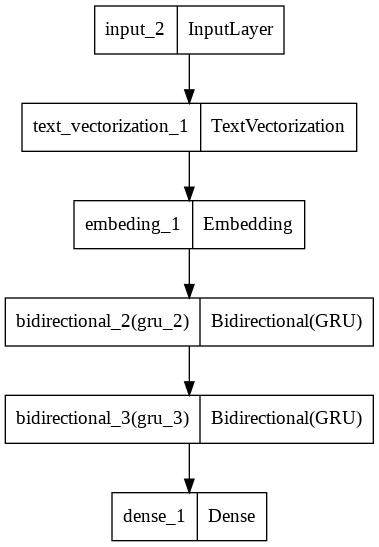

In [69]:
plot_model(model_1, show_layer_names=True)

In [ ]:
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(test_sentences, test_labels),
                              )

Epoch 1/5
1688/1688 [==============================] - 78s 42ms/step - loss: 0.8433 - accuracy: 0.5938 - val_loss: 0.8149 - val_accuracy: 0.6042
Epoch 2/5
1688/1688 [==============================] - 69s 41ms/step - loss: 0.7253 - accuracy: 0.6667 - val_loss: 0.8022 - val_accuracy: 0.6152
Epoch 3/5
1688/1688 [==============================] - 68s 40ms/step - loss: 0.6471 - accuracy: 0.7067 - val_loss: 0.8263 - val_accuracy: 0.6150
Epoch 4/5
 361/1688 [=====>........................] - ETA: 52s - loss: 0.5456 - accuracy: 0.7564

In [ ]:
model_1_pred_probs = model_1.predict(test_sentences)
model_1_preds = tf.squeeze(tf.argmax(model_1_pred_probs, axis = 1))
model_1_preds

In [ ]:
model_1_results = calculate_results(y_true = test_labels, y_pred = model_1_preds)
model_1_results 

Графічне відображення тренування моделі

In [ ]:
plot_history(model_1_history)

Порівняння результатів, отриманих у п.п. 3,4

In [ ]:
compare_baseline_to_new_results(model_0_results, model_1_results)

In [ ]:
df_compare = pd.DataFrame({'Baseline': model_0_results ,
                            'Bidirectional_GRU' : model_1_results
                           })
df_compare

In [ ]:
#df_compare.to_csv('df_compare.csv')